Akshay Zaveri, Dheeraj Banala, Arav Parikh

MATH 3094 - Mathematics of Machine Learning

Midterm Project

## Dataset

We selected the following dataset: https://archive.ics.uci.edu/ml/datasets/Heart+failure+clinical+records published by Davide Chicco and Giuseppe Jurman in the journal BMC Medical Informatics and Decision Making in 2020. The goal of this dataset is to predict mortality for patients with heart failure given certain pieces of relevant clinical information.



In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('heart_failure_clinical_records_dataset.csv')
df2 = np.genfromtxt('heart_failure_clinical_records_dataset.csv', delimiter=',', skip_header=1)
df.head()

In [ ]:
print(f"Length of Dataset: {len(df)}")
print(f"Number of Columns: {len(df.columns)}")

The dataset has 299 instances (patients) each with 13 attributes

Feature Attributes:
- anemia, diabetes, high blood pressure, smoking (Boolean encoded as integer)
- sex (binary encoded as integers)
- age, creatinine phosphokinase, ejection fraction, platelets, serum creatinine, serum sodium, time (real/integer)

Target Attribute:
- death event (Boolean encoded as integer) --> did the patient die in the follow-up time frame given by time attribute

In [ ]:
import seaborn as sns

print(f"Number of Positive (1) Instances: {len(df[df['DEATH_EVENT'] == 1])}")
print(f"Number of Negative (0) Instances: {len(df[df['DEATH_EVENT'] == 0])}")

_ = sns.countplot(df, x='DEATH_EVENT')

In [ ]:
df.skew().sort_values(ascending=False)

In [ ]:
df.corr().style.background_gradient(cmap='coolwarm')

In [ ]:
df.describe()

Preliminary EDA Findings:
- Class imbalance in favor of negative outcome --> common in medical datasets
- Most attributes skewed (heavily/slightly) right --> more lower values, mean > median
- No significant correlation between feature attributes --> linearly independent?
- Some correlation between length of follow-up period (time), ejection fraction, and serum creatinine and target 


- Average age of ~60 years old
- Average creatinine phosphopkinase level of 581.84 mcg/L >> normal level of ~120 mcg/L
- Average ejection fraction of 38% << normal range of 50-70% --> indicative of heart failure

In [ ]:
from sklearn.model_selection import train_test_split

y = df.pop('DEATH_EVENT')
X = df 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [ ]:
print(f"Shape of Training Data {X_train.shape}, Shape of Training Labels: {y_train.shape}")
print(f"Shape of Testing Data {X_test.shape}, Shape of Testing Labels: {y_test.shape}")

## PCA

We chose to perform PCA on our data before modeling to not only reduce data dimensionality/complexity, but also further analyze the different factors impacting heart failure. We implemented PCA manually first before checking our work with the scikit-learn version.

In [ ]:
import numpy as np

data = X
# Step 1: center data
centered_data = data - np.mean(data, axis=0)

# Step 2: find covariance matrix
D = np.dot(centered_data.transpose(), centered_data)/len(df)

# Step 3: find eigenvectors/eigenvalues of covariance matrix
L, P = np.linalg.eigh(D)
L = L[::-1]
P = P[:, ::-1]

In [ ]:
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.palettes import Spectral10, Category20
output_notebook()

eigenvalue_plot = figure(title="Covariance Matrix Eigenvalue Plot")
eigenvalue_plot.scatter(x=list(range(L.shape[0])), y=L, size=8)
eigenvalue_plot.line(x=list(range(L.shape[0])), y=L, color='red')
show(eigenvalue_plot)

In [ ]:
for i, x in enumerate(L):
  print(f"Eigenvalue {i} is {x}")

In [ ]:
# Step 4: project data onto principal components
PC = np.dot(centered_data, P[:, :2])
PC[:, 0] *= -1

colors=['red', 'blue']
color_list = [colors[int(y[i])] for i in range(299)]
PC_plot = figure(title="First Two Principal Components Plot (manual)")
PC_plot.scatter(x=PC[:, 0], y=PC[:, 1], color=color_list)
show(PC_plot)

As shown above, the first principle component captures the majority of the variance in the data, and misleadingly appears to be the only component with a non-zero eigenvalue. Upon further inspection and our subsequent verification with scikit-learn, however, we learned that the magnitude of the first eigenvalue overshadows the rest and, accordingly, causes this illusion.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=12)

PC2 = pca.fit_transform(data)

colors=['red', 'blue']
color_list = [colors[int(y[i])] for i in range(299)]
PC2_plot = figure(title="First 2 Principal Components Plot (scikit-learn)")
PC2_plot.scatter(x=PC2[:, 0], y=PC2[:, 1], color=color_list)
show(PC2_plot)

In [ ]:
exp_var = pca.explained_variance_ratio_
variance_plot = figure(title="Explained Variance Ratio Plot")
variance_plot.scatter(x=list(range(L.shape[0])), y=exp_var, size=8)
variance_plot.line(x=list(range(L.shape[0])), y=exp_var, color='red')
show(variance_plot)

In [ ]:
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=12)
ss = StandardScaler()

data2 = ss.fit_transform(df2[:, :-1])
PC2 = pca.fit_transform(data2)

source = ColumnDataSource({'PC0':PC2[:,0],'PC1':PC2[:,1],'age':df2[:,0],'anaemia':df2[:,1],'creatinine_phosphokinase':df2[:,2],'diabetes':df2[:,3],'ejection_fraction':df2[:,4], 'high_blood_pressure':df2[:,5], 'platelets':df2[:,6], 'serum_creatinine':df2[:,7], 'serum_sodium':df2[:,8], 'sex':df2[:,9], 'smoking':df2[:,10], 'time':df2[:,11]})
scatter_plot=figure(title="PCA Plot with Loadings")
scatter_plot.scatter(x='PC0', y='PC1', source=source)
scatter_plot.add_tools(HoverTool(tooltips=[("age","@age"),('anaemia','@anaemia'),('creatinine_phosphokinase','@creatinine_phosphokinase'),('diabetes','@diabetes'),('ejection_fraction','@ejection_fraction'),('high_blood_pressure','@high_blood_pressure'),('platelets','@platelets'),('serum_creatinine','@serum_creatinine'),('serum_sodium','@serum_sodium'),('sex','@sex'),('smoking','@smoking'),('time','@time')]))
loadings = ['age','anaemia','creatinine_phosphokinase','diabetes','ejection_fraction','high_blood_pressure','platelets','serum_creatinine','serum_sodium','sex','smoking','time']
for i in range(12):
    scatter_plot.line(x=[0, P[i, 0]], y=[0, P[i, 1]], color=Category20[12][i], line_width=3, legend_label=loadings[i])
show(scatter_plot)

As shown above, due to the scale of our data shown by the first principal component being orders of magnitude larger than any others, the loadings on our graph were nearly impossible to see due to how small they were. We resolved this by standardizing the data, but even then the loadings for almost all of the attributes were too small to see, and only those for creatinine phosphokinase and platelets were visible at a standard scale. In the end, performing PCA on our dataset did not yield very great results because of the cascading effects of having a single dominant principal component. The findings of the case study from which we got the dataset concluded that survival could be accurately predicted with just two of the features, and we believe this to be an explanation for why our PCA with 12 features was unsuccessful. Many of the features were just extra noise which made it difficult to identify how the few important features impacted survival.

## Logistic Regression

We first modeled the data with the logistic regression algorithm since the binary classification nature of this problem is something that logistic regression handles quite well.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *

log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(X_train, y_train)
print(f"Logistic Regression Test Accuracy: {log_reg.score(X_test, y_test)}")

Logistic Regression Test Accuracy: 0.8666666666666667


### Coefficients

We looked at the coefficients for each of the features after training the logistic regression as a means of gaining some insight into which features matter the most in predicting patient mortality.

In [ ]:
np.set_printoptions(precision=3, suppress=True)
coefs = log_reg.coef_.sort
for i in range(len(df.columns)):
  print(f"{list(df.columns)[i]} Coefficient: {coefs[0][i]}")

TypeError: ignored

As shown above, the age, ejection_fraction, and time features had coefficients with the greatest magnitudes and were, as a result, valued the most for predictors of whether a patient would survive or not, supporting our previous findings during the correlation analysis. This makes sense in the context of our data as large discrepancies in age and the volume of blood being pumped by the heart would result in very different chances of survival.

### Confusion Matrix

This matrix shows the counts of true and false positives and negatives for the predictions made by logistic regression. We also included statistics for precision and recall which provide insight into the model's performance. The recall value indicates how good the model is at correctly identifying positives, and the precision value indicates how good the model is at not misclassifying negatives as positives.

Recall: 0.65
Precision: 0.8125


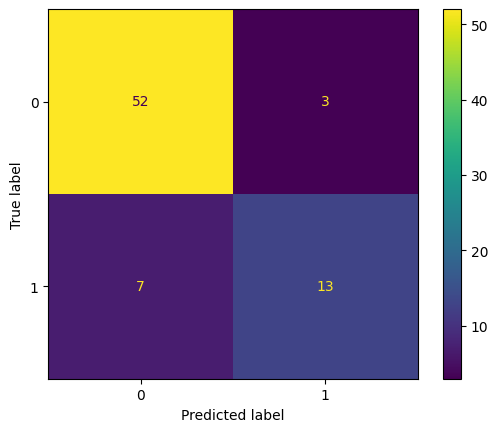

In [ ]:
l_y_pred = log_reg.predict(X_test)
l_conf_matrix = confusion_matrix(y_test, l_y_pred)
l_cmd = ConfusionMatrixDisplay(l_conf_matrix)
l_recall = recall_score(y_test, l_y_pred)
l_prec = precision_score(y_test, l_y_pred)
l_cmd.plot()
print("Recall: " + str(l_recall))
print("Precision: " + str(l_prec))

## Naive Bayes

We also decided to model the data with the popular Multinomial, Bernoulli, and Gaussian variants of the Naive Bayes classifier. We went in with the expectation that the Gaussian variant would outperform the others as its underlying assumption that each feature is normally distributed was more appropriate for this use case, especially when considering that Multinomial Naive Bayes works best when features specify event frequencies and Bernoulli Naive Bayes tends to work better when features are independent binary variables, both of which are not exactly the case here. (https://www.geeksforgeeks.org/naive-bayes-classifiers/)

In [ ]:
from sklearn.naive_bayes import *

mnb = MultinomialNB()
mnb.fit(X_train, y_train)
print(f"Multinomial Naive Bayes Test Accuracy: {mnb.score(X_test, y_test)}")

bnb = BernoulliNB()
bnb.fit(X_train, y_train)
print(f"Bernoulli Naive Bayes Test Accuracy: {bnb.score(X_test, y_test)}")

gnb = GaussianNB()
gnb.fit(X_train, y_train)
print(f"Gaussian Naive Bayes Test Accuracy: {gnb.score(X_test, y_test)}")

Multinomial Naive Bayes Test Accuracy: 0.6
Bernoulli Naive Bayes Test Accuracy: 0.7333333333333333
Gaussian Naive Bayes Test Accuracy: 0.8533333333333334


Recall: 0.5
Precision: 0.9090909090909091


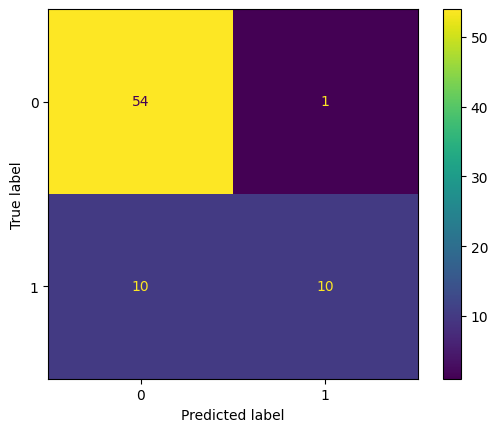

In [ ]:
g_y_pred = gnb.predict(X_test)
g_conf_matrix = confusion_matrix(y_test, g_y_pred)
g_cmd = ConfusionMatrixDisplay(g_conf_matrix)
g_recall = recall_score(y_test, g_y_pred)
g_prec = precision_score(y_test, g_y_pred)
g_cmd.plot()
print("Recall: " + str(g_recall))
print("Precision: " + str(g_prec))

## Conclusions

After training the various classifiers on our data, we learned that logistic regression performs the best on the testing data. The performance of the models is measured by their ability to predict deaths in patients with heart failure based on multiple attributes. However, since the dataset which we used was not very large to begin with, we cannot conclusively say that logistic regression would outperform the other classifiers with a more robust dataset, nor can we generalize the results to the real world.

The recall and precision values from the confusion matrices provide additional metrics to compare the models with. Despite having a slightly worse accuracy, the Gaussian Naive Bayes classifier had a noticeably better precision than logistic regression, while logistic regression had the better recall. This tells us that in situations where it is more important not to misclassify a result as positive, Naive Bayes might be the better option. For example, a disease which has a dangerous or risky treatment might be a context in which one would prioritize having minimal false positives. On the flip side, if catching as many positives as possible is the priority, one might choose logistic regression for its better recall.

We looked into some reasons as to why logistic regression had a slight edge for our dataset. One potential reason is that Naive Bayes operates on the assumption that the features are independent of one another. While this holds up for the most part in our data, there are a couple features which have enough of a correlation to potentially affect the model. Another possible explanation is that Naive Bayes assumes that the dataset is balanced, however ours has significantly more negatives than positives. Logistic regression has methods such as regularization to account for an imbalance in classes, meaning that it is better equipped for our data.